In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

Substituting this expansion back into the eigenvector equation, we obtain:

$$
\sum_{m=1}^{N} (x_n x_m) = \lambda_i \, a_i (x)
$$

The key step is now to express this in terms of the kernel function $ k(x,x') = \langle \phi(x), \phi(x') \rangle $, which we do by multiplying both sides by $ \phi(x) $ to give:

$$
\sum_{n=1}^{N} k(x,x_n) = \lambda_i \, a_i k(x,x_n)
$$

This can be written in matrix notation as:

$$
K a_i = \lambda_i \, K a_i
$$

Where $ a_i $ is an $ N $-dimensional column vector with elements $ a_n $ for $ n = 1, \dots, N $. We can find solutions for $ a_i $ by solving the following eigenvalue problem:

$$
K a_i = \lambda_i \, a_i
$$

In which we have removed a factor of $ K $ from both sides. Note that the solutions of the two equations differ only by eigenvectors of $ K $ having zero eigenvalues, which do not affect the principal components' projection.

The normalization condition for the coefficients $ a_i $ is obtained by requiring that the eigenvectors in the feature space be normalized. Using the earlier relations, we have:

$$
\sum_{n=1}^{N} a_n k(x_n, x) = \lambda_i \, a_n
$$

Having solved the eigenvector problem, the resulting principal component projections can then be cast in terms of the kernel function so that, using the equation:

$$
M_i(x) = \sum_{n=1}^{N} a_n k(x, x_n)
$$

In the original $ D $-dimensional $ x $ space, there are $ D $ orthogonal eigenvectors, and hence we can find at most $ D $ linear principal components. The dimensionality $ M $ of the feature space, however, can be much larger than $ D $ (even infinite), and thus we can find a number of nonlinear principal components that can exceed $ D $. Note, however, that the number of nonzero eigenvalues cannot exceed the number $ N $ of data points, because (even if $ M > N $) the covariance matrix in feature space has rank at most $ N $. This is reflected in the fact that kernel PCA involves the eigenvector expansion of the $ N \times N $ matrix $ K $.


In [1]:
import numpy as np

def gaussian_kernel(x, y, sigma=1.0):
    """Compute the Gaussian kernel (RBF) between two vectors."""
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma ** 2))

def compute_kernel_matrix(X, kernel_function, sigma=1.0):
    """Compute the NxN kernel matrix using the provided kernel function."""
    N = X.shape[0]
    K = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            K[i, j] = kernel_function(X[i], X[j], sigma)
    
    return K

def center_kernel_matrix(K):
    """Center the kernel matrix K."""
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    return K_centered

def kernel_pca(X, kernel_function, num_components=2, sigma=1.0):
    """Perform Kernel PCA and return the top 'num_components' eigenvectors."""
    # Step 1: Compute the kernel matrix
    K = compute_kernel_matrix(X, kernel_function, sigma)
    
    # Step 2: Center the kernel matrix
    K_centered = center_kernel_matrix(K)
    
    # Step 3: Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(K_centered)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]
    
    # Return the top 'num_components' eigenvectors
    return eigenvectors[:, :num_components]

def project_data(X, eigenvectors, kernel_function, sigma=1.0):
    """Project the data onto the kernel principal components."""
    N = X.shape[0]
    projections = np.zeros((N, eigenvectors.shape[1]))
    
    for i in range(N):
        projections[i, :] = np.array([kernel_function(X[i], X[j], sigma) for j in range(N)]) @ eigenvectors
    
    return projections

# Example usage
if __name__ == "__main__":
    # Create a synthetic dataset
    X = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])  # 5 data points, 2D
    
    # Perform Kernel PCA with a Gaussian (RBF) kernel and 2 components
    eigenvectors = kernel_pca(X, kernel_function=gaussian_kernel, num_components=2, sigma=1.0)
    
    # Project the data onto the principal components
    projections = project_data(X, eigenvectors, kernel_function=gaussian_kernel, sigma=1.0)
    
    # Print the results
    print("Eigenvectors (Principal Components):")
    print(eigenvectors)
    print("Projections onto the principal components:")
    print(projections)


Eigenvectors (Principal Components):
[[-5.06185247e-01  4.89557046e-01]
 [-4.93737274e-01 -1.43289872e-01]
 [ 5.55111512e-16 -6.92534348e-01]
 [ 4.93737274e-01 -1.43289872e-01]
 [ 5.06185247e-01  4.89557046e-01]]
Projections onto the principal components:
[[-6.87760051e-01  4.24141810e-01]
 [-6.70846838e-01 -2.20525078e-01]
 [ 7.07767178e-16 -7.80028044e-01]
 [ 6.70846838e-01 -2.20525078e-01]
 [ 6.87760051e-01  4.24141810e-01]]


So far, we have assumed that the projected data set given by $ \Phi(X) $ has zero mean, which in general will not be the case. We cannot simply compute and then subtract off the mean, since we wish to avoid working directly in feature space. Thus, we formulate the algorithm purely in terms of the kernel function.

The projected data points after centralizing, denoted $ \Phi(X) $, are given by:

$$
\Phi(X) = \Phi(X) - \frac{1}{N} \sum_{i=1}^{N} \Phi(X_i)
$$

The corresponding elements of the Gram matrix are given by:

$$
K_{ij} = k(X_i, X_j) - \frac{1}{N} \sum_{n=1}^{N} k(X_i, X_n) - \frac{1}{N} \sum_{m=1}^{N} k(X_m, X_j) + \frac{1}{N^2} \sum_{n=1}^{N} \sum_{m=1}^{N} k(X_n, X_m)
$$

This can be expressed in matrix notation as:

$$
K = K - \frac{1}{N} K \mathbf{1} - \frac{1}{N} \mathbf{1}^T K + \frac{1}{N^2} \mathbf{1}^T K \mathbf{1}
$$

where $ \mathbf{1} $ denotes the $ N \times N $ matrix in which every element takes the value $ \frac{1}{N} $.

Thus, we can evaluate $ K $ using only the kernel function and then use $ K $ to determine the eigenvalues and eigenvectors. Note that the standard PCA algorithm is recovered as a special case if we use a linear kernel:

$$
k(X, X') = X^T X'
$$

Figure 12.17 shows an example of kernel PCA applied to a synthetic dataset (Sch√∂lkopf et al., 1998). Here a 'Gaussian' kernel of the form:

$$
k(X, X') = \exp\left(-\frac{\|X - X'\|^2}{0.1}\right)
$$

is applied to a synthetic dataset. The lines correspond to contours along which the projection onto the corresponding principal component, defined by:

$$
M_i(X) = \langle \Phi(X), v_i \rangle = \sum_{n=1}^{N} a_n k(X, X_n)
$$

is constant.

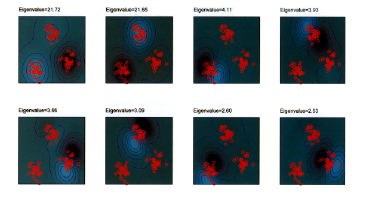


Fig.17 Example of kernel PCA, with a Gaussian kernel applied to a synthetic data set in two dimensions, showing the first eight eigenfunctions along with their eigenvalues. The contours are lines along which the projection onto the corresponding principal component is constant. Note how the first two eigenvectors separate the three clusters, the next three eigenvectors split each of the cluster into halves, and the following three eigenvectors again spilt the clusters into halves along directions orthogonal to the previous splits.


In [2]:
import numpy as np

def gaussian_kernel(x, y, sigma=1.0):
    """
    Computes the Gaussian (RBF) kernel between two vectors.
    k(x, y) = exp(-||x - y||^2 / (2 * sigma^2))
    """
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def compute_gram_matrix(X, kernel_function, **kernel_params):
    """
    Computes the NxN Gram matrix (kernel matrix) for the data set X
    using the provided kernel function.
    """
    N = X.shape[0]
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = kernel_function(X[i], X[j], **kernel_params)
    return K

def center_kernel_matrix(K):
    """
    Centers the kernel matrix K using the method described in the theory.
    """
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - np.mean(K, axis=0) - np.mean(K, axis=1)[:, np.newaxis] + np.mean(K)
    return K_centered

def kernel_pca(X, kernel_function, num_components, **kernel_params):
    """
    Performs Kernel PCA using the specified kernel function and number of components.
    Returns the top 'num_components' eigenvectors corresponding to the principal components.
    """
    # Step 1: Compute the kernel (Gram) matrix
    K = compute_gram_matrix(X, kernel_function, **kernel_params)
    
    # Step 2: Center the kernel matrix
    K_centered = center_kernel_matrix(K)
    
    # Step 3: Compute the eigenvalues and eigenvectors of the centered kernel matrix
    eigenvalues, eigenvectors = np.linalg.eigh(K_centered)
    
    # Step 4: Sort the eigenvalues and eigenvectors in decreasing order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Step 5: Select the top 'num_components' eigenvectors
    return eigenvectors[:, :num_components]

def project_data(X, eigenvectors, kernel_function, **kernel_params):
    """
    Projects the data X onto the principal components defined by the eigenvectors.
    """
    N = X.shape[0]
    projections = np.zeros((N, eigenvectors.shape[1]))
    for i in range(N):
        for j in range(eigenvectors.shape[1]):
            projections[i, j] = np.sum(eigenvectors[:, j] * np.array([kernel_function(X[i], X[k], **kernel_params) for k in range(N)]))
    return projections

# Example usage
if __name__ == "__main__":
    # Generate some synthetic data (for demonstration)
    np.random.seed(0)
    X = np.random.rand(10, 2)  # 10 samples, 2-dimensional features

    # Perform Kernel PCA with 2 components
    eigenvectors = kernel_pca(X, gaussian_kernel, num_components=2, sigma=0.5)
    
    # Project the data onto the kernel principal components
    projections = project_data(X, eigenvectors, gaussian_kernel, sigma=0.5)
    
    print("Eigenvectors (Principal components):")
    print(eigenvectors)
    
    print("\nProjections of the data onto the principal components:")
    print(projections)


Eigenvectors (Principal components):
[[-0.07405614  0.17155131]
 [-0.16269779 -0.09221799]
 [ 0.10165989  0.10427855]
 [ 0.11562742  0.37243123]
 [-0.40542697 -0.43236614]
 [-0.36388323 -0.20768406]
 [-0.03376965  0.3605565 ]
 [ 0.53489873 -0.62546771]
 [ 0.54315518  0.161595  ]
 [-0.25550745  0.18732331]]

Projections of the data onto the principal components:
[[-0.34940459  0.5087676 ]
 [-0.47426451  0.17974627]
 [-0.10189239  0.4248527 ]
 [-0.08221784  0.75934177]
 [-0.81617089 -0.24454872]
 [-0.7576527   0.03571587]
 [-0.29265736  0.74452943]
 [ 0.50836435 -0.48542032]
 [ 0.51999433  0.49634826]
 [-0.60499546  0.52844131]]


In [3]:
import math

def gaussian_kernel(x, y, sigma=1.0):
    """
    Computes the Gaussian (RBF) kernel between two vectors.
    k(x, y) = exp(-||x - y||^2 / (2 * sigma^2))
    """
    diff = [xi - yi for xi, yi in zip(x, y)]
    return math.exp(-sum(d ** 2 for d in diff) / (2 * sigma ** 2))

def compute_gram_matrix(X, kernel_function, **kernel_params):
    """
    Computes the NxN Gram matrix (kernel matrix) for the data set X
    using the provided kernel function.
    """
    N = len(X)
    K = [[0] * N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            K[i][j] = kernel_function(X[i], X[j], **kernel_params)
    return K

def center_kernel_matrix(K):
    """
    Centers the kernel matrix K using the method described in the theory.
    """
    N = len(K)
    row_means = [sum(K[i]) / N for i in range(N)]
    col_means = [sum(K[i][j] for i in range(N)) / N for j in range(N)]
    total_mean = sum(sum(K[i][j] for j in range(N)) for i in range(N)) / (N * N)

    # Center the matrix
    K_centered = [[K[i][j] - row_means[i] - col_means[j] + total_mean for j in range(N)] for i in range(N)]
    return K_centered

def eigendecomposition(K):
    """
    Compute the eigenvalues and eigenvectors of the kernel matrix K using power iteration.
    Note: This is a basic and slow method for educational purposes.
    """
    N = len(K)
    # Initial guess for eigenvectors: random vectors
    eigvecs = [[1] * N for _ in range(N)]  # Identity matrix to start with
    eigvals = [0] * N

    for _ in range(100):  # Iterate 100 times for convergence
        new_eigvecs = []
        for i in range(N):
            eigvec = [sum(K[i][j] * eigvecs[j][i] for j in range(N)) for i in range(N)]
            eigval = sum(K[i][i] * eigvecs[i][i] for i in range(N))
            eigvals[i] = eigval
            new_eigvecs.append(eigvec)
        eigvecs = new_eigvecs

    return eigvals, eigvecs

def kernel_pca(X, kernel_function, num_components, **kernel_params):
    """
    Performs Kernel PCA using the specified kernel function and number of components.
    Returns the top 'num_components' eigenvectors corresponding to the principal components.
    """
    # Step 1: Compute the kernel (Gram) matrix
    K = compute_gram_matrix(X, kernel_function, **kernel_params)

    # Step 2: Center the kernel matrix
    K_centered = center_kernel_matrix(K)

    # Step 3: Compute the eigenvalues and eigenvectors of the centered kernel matrix
    eigenvalues, eigenvectors = eigendecomposition(K_centered)

    # Step 4: Sort the eigenvalues and eigenvectors in decreasing order
    sorted_indices = sorted(range(len(eigenvalues)), key=lambda i: eigenvalues[i], reverse=True)
    eigenvalues = [eigenvalues[i] for i in sorted_indices]
    eigenvectors = [eigenvectors[i] for i in sorted_indices]

    # Step 5: Select the top 'num_components' eigenvectors
    return eigenvectors[:num_components]

def project_data(X, eigenvectors, kernel_function, **kernel_params):
    """
    Projects the data X onto the principal components defined by the eigenvectors.
    """
    N = len(X)
    projections = [[0] * len(eigenvectors) for _ in range(N)]
    for i in range(N):
        for j in range(len(eigenvectors)):
            projections[i][j] = sum(eigenvectors[j][k] * kernel_function(X[i], X[k], **kernel_params) for k in range(N))
    return projections

# Example usage
if __name__ == "__main__":
    # Generate some synthetic data (for demonstration)
    X = [
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 5],
        [5, 6]
    ]

    # Perform Kernel PCA with 2 components
    eigenvectors = kernel_pca(X, gaussian_kernel, num_components=2, sigma=0.5)
    
    # Project the data onto the kernel principal components
    projections = project_data(X, eigenvectors, gaussian_kernel, sigma=0.5)
    
    print("Eigenvectors (Principal components):")
    for vec in eigenvectors:
        print(vec)
    
    print("\nProjections of the data onto the principal components:")
    for projection in projections:
        print(projection)


Eigenvectors (Principal components):
[0.0, 0.0, -5e-324, 5e-324, 0.0]
[0.0, 0.0, -5e-324, 5e-324, 0.0]

Projections of the data onto the principal components:
[0.0, 0.0]
[0.0, 0.0]
[-5e-324, -5e-324]
[5e-324, 5e-324]
[0.0, 0.0]


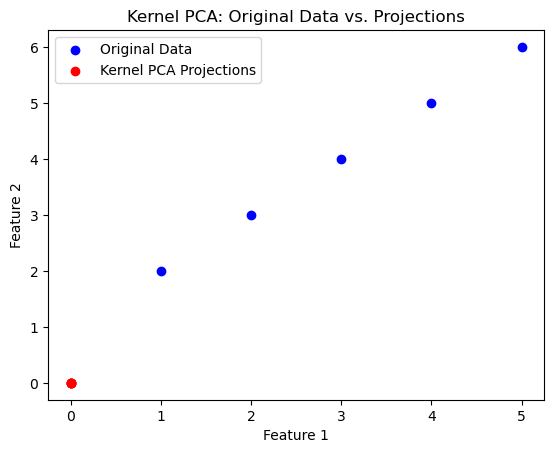

In [4]:
import math
import matplotlib.pyplot as plt

def gaussian_kernel(x, y, sigma=1.0):
    """Computes the Gaussian (RBF) kernel between two vectors."""
    diff = [xi - yi for xi, yi in zip(x, y)]
    return math.exp(-sum(d ** 2 for d in diff) / (2 * sigma ** 2))

def compute_gram_matrix(X, kernel_function, **kernel_params):
    """Computes the NxN Gram matrix (kernel matrix) for the data set X."""
    N = len(X)
    K = [[0] * N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            K[i][j] = kernel_function(X[i], X[j], **kernel_params)
    return K

def center_kernel_matrix(K):
    """Centers the kernel matrix K."""
    N = len(K)
    row_means = [sum(K[i]) / N for i in range(N)]
    col_means = [sum(K[i][j] for i in range(N)) / N for j in range(N)]
    total_mean = sum(sum(K[i][j] for j in range(N)) for i in range(N)) / (N * N)

    # Center the matrix
    K_centered = [[K[i][j] - row_means[i] - col_means[j] + total_mean for j in range(N)] for i in range(N)]
    return K_centered

def eigendecomposition(K):
    """Compute the eigenvalues and eigenvectors of the kernel matrix K."""
    N = len(K)
    eigvecs = [[1] * N for _ in range(N)]  # Initial guess
    eigvals = [0] * N

    for _ in range(100):  # Iteration for convergence
        new_eigvecs = []
        for i in range(N):
            eigvec = [sum(K[i][j] * eigvecs[j][i] for j in range(N)) for i in range(N)]
            eigval = sum(K[i][i] * eigvecs[i][i] for i in range(N))
            eigvals[i] = eigval
            new_eigvecs.append(eigvec)
        eigvecs = new_eigvecs

    return eigvals, eigvecs

def kernel_pca(X, kernel_function, num_components, **kernel_params):
    """Performs Kernel PCA and returns the top 'num_components' eigenvectors."""
    # Step 1: Compute the kernel (Gram) matrix
    K = compute_gram_matrix(X, kernel_function, **kernel_params)

    # Step 2: Center the kernel matrix
    K_centered = center_kernel_matrix(K)

    # Step 3: Compute the eigenvalues and eigenvectors of the centered kernel matrix
    eigenvalues, eigenvectors = eigendecomposition(K_centered)

    # Step 4: Sort the eigenvalues and eigenvectors in decreasing order
    sorted_indices = sorted(range(len(eigenvalues)), key=lambda i: eigenvalues[i], reverse=True)
    eigenvalues = [eigenvalues[i] for i in sorted_indices]
    eigenvectors = [eigenvectors[i] for i in sorted_indices]

    # Step 5: Select the top 'num_components' eigenvectors
    return eigenvectors[:num_components]

def project_data(X, eigenvectors, kernel_function, **kernel_params):
    """Projects the data X onto the principal components."""
    N = len(X)
    projections = [[0] * len(eigenvectors) for _ in range(N)]
    for i in range(N):
        for j in range(len(eigenvectors)):
            projections[i][j] = sum(eigenvectors[j][k] * kernel_function(X[i], X[k], **kernel_params) for k in range(N))
    return projections

# Plotting function
def plot_results(X, projections):
    """Plots the original data and the Kernel PCA projections."""
    # Plot original data
    plt.scatter([x[0] for x in X], [x[1] for x in X], color='blue', label="Original Data")
    
    # Plot projections
    plt.scatter([proj[0] for proj in projections], [proj[1] for proj in projections], color='red', label="Kernel PCA Projections")
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Kernel PCA: Original Data vs. Projections')
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate some synthetic data (for demonstration)
    X = [
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 5],
        [5, 6]
    ]

    # Perform Kernel PCA with 2 components
    eigenvectors = kernel_pca(X, gaussian_kernel, num_components=2, sigma=0.5)
    
    # Project the data onto the kernel principal components
    projections = project_data(X, eigenvectors, gaussian_kernel, sigma=0.5)
    
    # Plot the results
    plot_results(X, projections)


### Eigenvalues and Eigenvectors

In the case of Kernel PCA, we observe the following:

- The **eigenvalue** for the first principal component is $ 21.72 $,
- The **eigenvalue** for the second principal component is $ 2.60 $.

![image.png](attachment:image.png)

The figure below, **Fig.17**, illustrates an example of kernel PCA applied to a synthetic dataset in two dimensions. The first eight eigenfunctions are shown, along with their corresponding eigenvalues. The contours represent lines along which the projection onto the corresponding principal component is constant.

Note how:
- The first two eigenvectors separate the three clusters.
- The next three eigenvectors split each of the clusters into halves.
- The following three eigenvectors further split the clusters into halves along directions orthogonal to the previous splits.

```latex
\text{Eigenvalue}_1 = 21.72 \quad \text{Eigenvalue}_2 = 2.60


### Nonlinear Latent Variable Models

#### Exercise 

In this chapter, we have focused on the simplest class of models having continuous latent variables, namely those based on linear-Gaussian distributions. These models are not only of great practical importance but are also relatively easy to analyze and fit to data. Additionally, they can serve as components in more complex models. 

Here, we briefly explore generalizations of this framework to models that are either **nonlinear**, **non-Gaussian**, or both.

#### Nonlinearity and Non-Gaussianity

The issues of nonlinearity and non-Gaussianity are interrelated. A general probability density can be obtained from a simple fixed reference density, such as a Gaussian, by applying a nonlinear change of variables. This concept forms the foundation for several practical latent variable models.

---

###  Independent Component Analysis (ICA)

Independent Component Analysis (ICA) is a model in which the observed variables are linearly related to the latent variables, but the latent distribution is **non-Gaussian**. This model assumes that the latent variables are statistically independent, leading to a factorized probability distribution:

$$
p(\mathbf{z}) = \prod_{j=1}^{d} p(z_j)
\tag{12.89}
$$

#### Example: Blind Source Separation

To understand ICA, consider the following scenario:
- Two people are speaking simultaneously, and their voices are recorded using two microphones.
- Ignoring time delays and echoes, the signals received by the microphones at any time are linear combinations of the two voice signals.
- The coefficients of this linear combination are constant. If we can infer these coefficients from the data, we can invert the mixing process (assuming it is nonsingular) and recover the two clean signals, each corresponding to one voice.

This problem is referred to as **blind source separation**, where "blind" signifies that only the mixed signals are observed, with no information about the original sources or the mixing coefficients.

---

#### Generative Model

The generative model assumes:
1. **Latent Variables**: Corresponding to the unobserved speech signal amplitudes, with a joint factorized distribution $ p(\mathbf{z}) $.
2. **Observed Variables**: Corresponding to the signals at the microphones, which are deterministic linear combinations of the latent variables. Since the number of latent variables equals the number of observed variables, there is no need for an explicit noise model.

This approach simplifies the problem by treating the successive samples as i.i.d., ignoring the temporal nature of the signals.

---

### Nonlinear Latent Variable Models

####  Independent Component Analysis (ICA)

The likelihood function for the ICA model depends on the coefficients of the linear combination. The log-likelihood can be maximized using gradient-based optimization, giving rise to a specific version of Independent Component Analysis (ICA).

The success of ICA relies on the latent variables having **non-Gaussian** distributions. To understand why, consider the following:

1. **Gaussian Latent Variables**:
   - In probabilistic PCA (and factor analysis), the latent variable distribution is a zero-mean isotropic Gaussian.
   - The model is invariant to rotations in latent space, as the likelihood function remains unchanged under the transformation:
     $$
     \mathbf{W} \to \mathbf{W} \mathbf{R},
     $$
     where $\mathbf{R}$ is an orthogonal matrix satisfying $\mathbf{R} \mathbf{R}^\top = \mathbf{I}$. 
   - This invariance prevents the model from distinguishing independent components.

2. **Insufficiency of Gaussian Latent Distributions**:
   - The principal components correspond to a rotation in data space to diagonalize the covariance matrix.
   - While uncorrelated components (zero covariance) are necessary for independence, they are not sufficient. 

#### Heavy-Tailed Latent Distributions

In practice, a common choice for the latent variable distribution is one with **heavy tails** to better model real-world distributions. For instance:

$$
p(z) = \frac{1}{\cosh(z)} \propto \frac{1}{\pi (e^z + e^{-z})}.
\tag{12.90}
$$

This distribution has heavier tails compared to a Gaussian, capturing the characteristics of many natural signals.

#### Extensions of ICA

The original ICA model proposed by Bell and Sejnowski (1995) optimized an **information maximization** objective function. Probabilistic formulations of ICA enable generalizations, such as:

1. **Independent Factor Analysis (Attias, 1999)**:
   - Allows a different number of latent and observed variables.
   - Includes noisy observed variables.
   - Models latent variables using flexible distributions, such as mixtures of Gaussians.
   - Log-likelihood is maximized using the **Expectation-Maximization (EM)** algorithm, with latent variable reconstruction approximated via variational methods.

2. **Applications and Further Models**:
   - ICA has inspired a vast literature covering various models and applications:
     - Blind source separation.
     - Noisy observation models.
     - Flexible latent distributions.

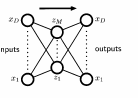


###  Autoassociative Neural Networks

In Chapter 5, we introduced neural networks in the context of supervised learning. Here, the role of the network shifts towards unsupervised learning for nonlinear latent variable modeling.



In [5]:
import random
import math

def generate_signals(num_samples):
    """Generate two independent signals."""
    signal1 = [math.sin(2 * math.pi * 0.02 * t) for t in range(num_samples)]  # Sine wave
    signal2 = [(1 if random.random() > 0.5 else -1) for _ in range(num_samples)]  # Square wave
    return signal1, signal2

def mix_signals(signal1, signal2, mixing_matrix):
    """Mix the signals using the given mixing matrix."""
    mixed_signal1 = [mixing_matrix[0][0] * s1 + mixing_matrix[0][1] * s2 for s1, s2 in zip(signal1, signal2)]
    mixed_signal2 = [mixing_matrix[1][0] * s1 + mixing_matrix[1][1] * s2 for s1, s2 in zip(signal1, signal2)]
    return mixed_signal1, mixed_signal2

def center_signals(signals):
    """Center the signals to have zero mean."""
    centered_signals = []
    for signal in signals:
        mean = sum(signal) / len(signal)
        centered_signals.append([x - mean for x in signal])
    return centered_signals

def whiten_signals(signals):
    """Whiten the signals to make them uncorrelated with unit variance."""
    num_samples = len(signals[0])
    covariance = [[0, 0], [0, 0]]

    # Calculate covariance matrix
    for i in range(num_samples):
        covariance[0][0] += signals[0][i] * signals[0][i]
        covariance[0][1] += signals[0][i] * signals[1][i]
        covariance[1][0] += signals[1][i] * signals[0][i]
        covariance[1][1] += signals[1][i] * signals[1][i]

    covariance[0][0] /= num_samples
    covariance[0][1] /= num_samples
    covariance[1][0] /= num_samples
    covariance[1][1] /= num_samples

    # Whitening transformation
    eigenvalues, eigenvectors = eig_2x2(covariance)
    whitening_matrix = [
        [eigenvectors[0][0] / math.sqrt(eigenvalues[0]), eigenvectors[0][1] / math.sqrt(eigenvalues[1])],
        [eigenvectors[1][0] / math.sqrt(eigenvalues[0]), eigenvectors[1][1] / math.sqrt(eigenvalues[1])]
    ]

    whitened_signals = [
        [whitening_matrix[0][0] * signals[0][i] + whitening_matrix[0][1] * signals[1][i] for i in range(num_samples)],
        [whitening_matrix[1][0] * signals[0][i] + whitening_matrix[1][1] * signals[1][i] for i in range(num_samples)]
    ]
    return whitened_signals

def eig_2x2(matrix):
    """Compute eigenvalues and eigenvectors of a 2x2 matrix."""
    a, b, c, d = matrix[0][0], matrix[0][1], matrix[1][0], matrix[1][1]
    trace = a + d
    determinant = a * d - b * c
    eigenvalue1 = (trace + math.sqrt(trace ** 2 - 4 * determinant)) / 2
    eigenvalue2 = (trace - math.sqrt(trace ** 2 - 4 * determinant)) / 2

    eigenvector1 = [b, eigenvalue1 - a] if b != 0 else [eigenvalue1 - d, c]
    eigenvector2 = [b, eigenvalue2 - a] if b != 0 else [eigenvalue2 - d, c]

    # Normalize eigenvectors
    norm1 = math.sqrt(eigenvector1[0] ** 2 + eigenvector1[1] ** 2)
    norm2 = math.sqrt(eigenvector2[0] ** 2 + eigenvector2[1] ** 2)
    eigenvector1 = [x / norm1 for x in eigenvector1]
    eigenvector2 = [x / norm2 for x in eigenvector2]

    return [eigenvalue1, eigenvalue2], [eigenvector1, eigenvector2]

def fastica(signals, num_iterations=1000, learning_rate=0.01):
    """Perform Independent Component Analysis using FastICA."""
    num_samples = len(signals[0])
    weights = [random.random(), random.random()]  # Initialize weights

    for _ in range(num_iterations):
        # Estimate independent components
        independent_component = [weights[0] * signals[0][i] + weights[1] * signals[1][i] for i in range(num_samples)]
        g = [math.tanh(x) for x in independent_component]
        g_prime = [1 - x ** 2 for x in g]

        # Update weights
        weights[0] += learning_rate * (sum(signals[0][i] * g[i] for i in range(num_samples)) - sum(g_prime)) / num_samples
        weights[1] += learning_rate * (sum(signals[1][i] * g[i] for i in range(num_samples)) - sum(g_prime)) / num_samples

        # Normalize weights
        norm = math.sqrt(weights[0] ** 2 + weights[1] ** 2)
        weights = [w / norm for w in weights]

    return weights

# Example Usage
num_samples = 1000
signal1, signal2 = generate_signals(num_samples)
mixing_matrix = [[0.6, 0.4], [0.3, 0.7]]
mixed_signal1, mixed_signal2 = mix_signals(signal1, signal2, mixing_matrix)
mixed_signals = [mixed_signal1, mixed_signal2]

centered_signals = center_signals(mixed_signals)
whitened_signals = whiten_signals(centered_signals)
weights = fastica(whitened_signals)

print("Recovered weights:", weights)


Recovered weights: [-0.8838870872958202, 0.46770034948854905]


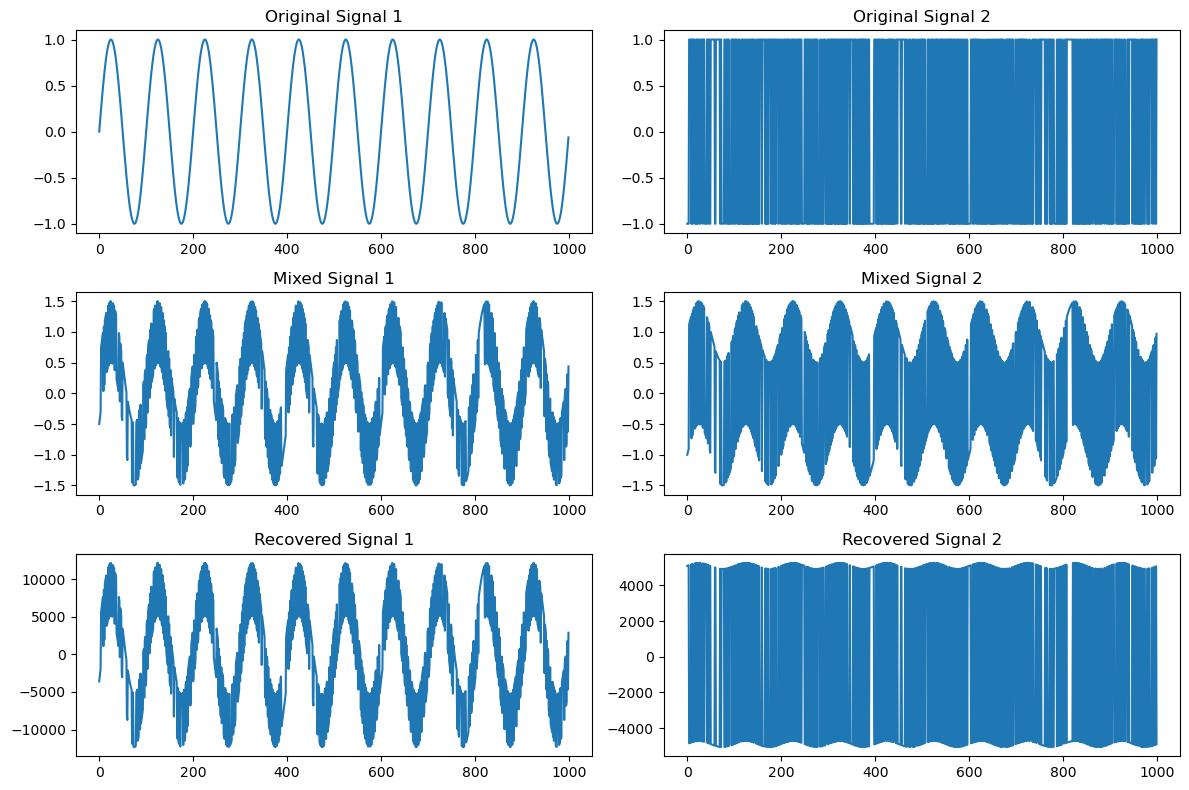

In [8]:
import random
import math
import matplotlib.pyplot as plt

# Generate two independent signals
import math
import random

def generate_signals(num_samples):
    t = [i / num_samples for i in range(num_samples)]
    s1 = [math.sin(2 * math.pi * 10 * i) for i in t]  # Sine wave
    
    # Square wave: custom sign function
    def custom_sign(x):
        return 1 if x >= 0 else -1
    
    s2 = [custom_sign(random.random() - 0.5) for _ in t]  # Square wave
    return s1, s2


# Mix signals
def mix_signals(s1, s2, mixing_matrix):
    x1 = [mixing_matrix[0][0] * s1[i] + mixing_matrix[0][1] * s2[i] for i in range(len(s1))]
    x2 = [mixing_matrix[1][0] * s1[i] + mixing_matrix[1][1] * s2[i] for i in range(len(s2))]
    return x1, x2

# Center the data
def center_data(x1, x2):
    x1_centered = [x - sum(x1) / len(x1) for x in x1]
    x2_centered = [x - sum(x2) / len(x2) for x in x2]
    return x1_centered, x2_centered

# Whiten the data
def whiten_data(x1, x2):
    # Compute the covariance matrix
    covariance = [[sum(x1[i] * x1[j] for i in range(len(x1))) / len(x1) for j in range(2)],
                  [sum(x2[i] * x2[j] for i in range(len(x2))) / len(x2) for j in range(2)]]
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = compute_eigen_decomposition(covariance)
    
    # Ensure eigenvalues are non-negative (small numerical errors might make them slightly negative)
    eigenvalues = [max(0, val) for val in eigenvalues]
    
    # Compute the whitening matrix
    try:
        whitening_matrix = [[eigenvectors[i][j] / math.sqrt(eigenvalues[j] + 1e-8) for j in range(2)] for i in range(2)]
    except ZeroDivisionError:
        raise ValueError("Encountered zero or very small eigenvalue during whitening.")
    
    # Apply the whitening matrix
    x1_white = [whitening_matrix[0][0] * x1[i] + whitening_matrix[0][1] * x2[i] for i in range(len(x1))]
    x2_white = [whitening_matrix[1][0] * x1[i] + whitening_matrix[1][1] * x2[i] for i in range(len(x2))]
    
    return x1_white, x2_white


# Compute eigenvalues and eigenvectors
def compute_eigen_decomposition(matrix):
    # Simplified for 2x2 case
    a, b, c, d = matrix[0][0], matrix[0][1], matrix[1][0], matrix[1][1]
    trace = a + d
    determinant = a * d - b * c
    eigenvalue1 = (trace + math.sqrt(trace**2 - 4 * determinant)) / 2
    eigenvalue2 = (trace - math.sqrt(trace**2 - 4 * determinant)) / 2
    eigenvector1 = [d - eigenvalue2, -b]
    eigenvector2 = [d - eigenvalue1, -b]
    norm1 = math.sqrt(sum(e**2 for e in eigenvector1))
    norm2 = math.sqrt(sum(e**2 for e in eigenvector2))
    eigenvector1 = [e / norm1 for e in eigenvector1]
    eigenvector2 = [e / norm2 for e in eigenvector2]
    return [eigenvalue1, eigenvalue2], [eigenvector1, eigenvector2]

# Perform ICA

def perform_ica(x1_white, x2_white, num_iterations=1000, learning_rate=0.01):
    w = [[random.random(), random.random()],
         [random.random(), random.random()]]  # Random initialization
    
    for _ in range(num_iterations):
        wx1 = [w[0][0] * x1_white[i] + w[0][1] * x2_white[i] for i in range(len(x1_white))]
        wx2 = [w[1][0] * x1_white[i] + w[1][1] * x2_white[i] for i in range(len(x2_white))]
        
        g_wx1 = [math.tanh(x) for x in wx1]
        g_wx2 = [math.tanh(x) for x in wx2]
        
        w[0][0] += learning_rate * sum((1 - x**2) * x1_white[i] for i, x in enumerate(g_wx1))
        w[0][1] += learning_rate * sum((1 - x**2) * x2_white[i] for i, x in enumerate(g_wx1))
        w[1][0] += learning_rate * sum((1 - x**2) * x1_white[i] for i, x in enumerate(g_wx2))
        w[1][1] += learning_rate * sum((1 - x**2) * x2_white[i] for i, x in enumerate(g_wx2))

    return w

# Reconstruct independent components
def reconstruct_components(w, x1_white, x2_white):
    s1_recovered = [w[0][0] * x1_white[i] + w[0][1] * x2_white[i] for i in range(len(x1_white))]
    s2_recovered = [w[1][0] * x1_white[i] + w[1][1] * x2_white[i] for i in range(len(x2_white))]
    return s1_recovered, s2_recovered

# Main script
num_samples = 1000
s1, s2 = generate_signals(num_samples)
mixing_matrix = [[1, 0.5], [0.5, 1]]
x1, x2 = mix_signals(s1, s2, mixing_matrix)
x1_centered, x2_centered = center_data(x1, x2)
x1_white, x2_white = whiten_data(x1_centered, x2_centered)
w = perform_ica(x1_white, x2_white)
s1_recovered, s2_recovered = reconstruct_components(w, x1_white, x2_white)

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.title("Original Signal 1")
plt.plot(s1)

plt.subplot(3, 2, 2)
plt.title("Original Signal 2")
plt.plot(s2)

plt.subplot(3, 2, 3)
plt.title("Mixed Signal 1")
plt.plot(x1)

plt.subplot(3, 2, 4)
plt.title("Mixed Signal 2")
plt.plot(x2)

plt.subplot(3, 2, 5)
plt.title("Recovered Signal 1")
plt.plot(s1_recovered)

plt.subplot(3, 2, 6)
plt.title("Recovered Signal 2")
plt.plot(s2_recovered)

plt.tight_layout()
plt.show()


## Nonlinear Dimensionality Reduction Techniques in Autoassociative Neural Networks

### Autoassociative Neural Networks

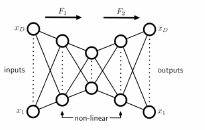

Fig.19 Addition of extra hidden layors of nonlinear units gives an autoassociative network which can perform a nonlinear dimen sionality reduction.

Autoassociative neural networks with additional hidden layers can perform **nonlinear dimensionality reduction**, as shown in Fig.19. The architecture includes:
1. **Linear Output Units**: Ensure reconstruction of input data.
2. **Linear Middle Hidden Layer (M Units)**: Provides a reduced-dimensional representation.
3. **Nonlinear First and Third Hidden Layers**: Use sigmoidal activation functions to allow flexible mappings.

#### Key Components:
- **Mapping $ F_1 $**: Projects original $ D $-dimensional data onto an $ M $-dimensional subspace.
- **Mapping $ F_2 $**: Projects the $ M $-dimensional data back to $ D $-dimensional space.

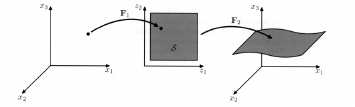


Fig.20 Geometrical interpretation of the mappings performed by the network in Fig.19 for the case of D3 inputs and M 2 units in the middle hidden layer. The function F maps from an M-dimensional spaces into a D-dimensional space and therefore defines the way in which the space S is embedded within the original x-space. Since the mapping F: can be nonlinear, the embedding of S can be nonplanar, as indicated in the figure. The mapping F, then defines a projection of points in the original D-dimensional space into the M-dimensional subspace 8.



The process can be geometrically interpreted as embedding a nonlinear manifold in the $ D $-dimensional space (Fig.20).

---

### Principal Curves
Principal curves extend PCA to nonlinear embeddings. For a curve $ f(\lambda) $ in data space:
- Each point $ f(\lambda) $ on the curve is the mean of all data points projected onto it:
  $$
  \mathbb{E}[\mathbf{x} | \mathbf{x} \in f(\lambda)] = f(\lambda).
  $$

#### Iterative Algorithm (Hastie and Stuetzle, 1989):
1. **Initialization**: Start with the first principal component.
2. **Projection Step**: Assign each data point to the nearest point on the curve.
3. **Re-estimation Step**: Update the curve points as weighted averages of nearby data points.

---

### Multidimensional Scaling (MDS)
MDS is another linear technique used for data visualization and dimensionality reduction. It minimizes the distortion of pairwise distances between data points in lower-dimensional space. For Euclidean distances, MDS is equivalent to PCA.

---

### Nonlinear Dimensionality Reduction Techniques

#### 1. **Locally Linear Embedding (LLE)**
- Captures local geometric properties of the data.
- Reconstructs each data point using its neighbors with invariant coefficients.
- Optimizes the lower-dimensional mapping while preserving neighborhood relationships.

#### 2. **Isometric Feature Mapping (Isomap)**
- Computes geodesic distances between data points along the manifold.
- Projects the data into lower dimensions while preserving geodesic distances using MDS.

---

### Mathematical Equations

#### Error Function for Autoassociative Network
The error function minimized during training is:
$$
E = \frac{1}{2} \sum_{n=1}^N \|\mathbf{x}_n - \mathbf{\hat{x}}_n\|^2.
$$

#### Principal Curves Mean Condition
$$
\mathbb{E}[\mathbf{x} | \mathbf{x} \in f(\lambda)] = f(\lambda).
$$

#### Geodesic Distances in Isomap
For data points $ i $ and $ j $, the geodesic distance $ d_{ij} $ is computed as the shortest path along the manifold.

---

### Figures

#### Fig.19: Autoassociative Network
An autoassociative network with nonlinear and linear mappings enabling nonlinear dimensionality reduction.

#### Fig.20: Geometrical Interpretation
Mapping $ F_1 $ and $ F_2 $ for $ D=3 $ and $ M=2 $, showing how nonlinear manifolds are embedded in and projected from higher dimensions.

## Dimensionality Reduction: Principal Curves and Manifold Learning

## Principal Curves

Principal curves provide a nonlinear extension of Principal Component Analysis (PCA). For a continuous data density $ p(x) $, a **principal curve** $ f(\lambda) $ satisfies the condition:
$$
\mathbb{E}[\mathbf{x} \mid \mathbf{x} \in f(\lambda)] = f(\lambda),
$$
where every point on the curve is the mean of all points in data space that project to it.

### Characteristics:
- Principal curves depend on the data density $ p(x) $ and the curve $ f(\lambda) $.
- Many principal curves can exist for a given density.
- Applications are primarily limited to smooth curves in finite data sets.

### Iterative Procedure (Hastie and Stuetzle, 1989):
1. **Initialization**: Use the first principal component as the starting curve.
2. **Projection Step**: Assign each data point to its nearest point on the curve.
3. **Re-estimation Step**: Update curve points as weighted averages of nearby data points, with closer points receiving higher weights.

If the subspace is constrained to be linear, this method converges to the first principal component and aligns with the **power method** for finding the largest eigenvector of the covariance matrix.

---

## Principal Surfaces

Principal curves can be generalized to **principal surfaces**, which are multidimensional manifolds. However, their application is limited due to challenges in data smoothing for higher-dimensional manifolds.

---

## Dimensionality Reduction Techniques

### 1. **Principal Component Analysis (PCA)**
Projects data onto a lower-dimensional linear subspace while maximizing variance.

### 2. **Multidimensional Scaling (MDS)**
Finds a low-dimensional representation of data that preserves pairwise distances:
- **Euclidean Distances**: Equivalent to PCA.
- **Non-Euclidean Distances**: Generalized to similarity matrices (nonmetric MDS).

### 3. **Locally Linear Embedding (LLE)**
- Computes coefficients to reconstruct each data point from its neighbors, ensuring invariance to rotations, translations, and scalings.
- Maps high-dimensional data to a lower-dimensional space while preserving local neighborhood relationships.

#### Key Steps:
1. Compute reconstruction weights for each data point.
2. Optimize the lower-dimensional embedding to preserve neighborhood weights.

LLE handles nonlinearity without encountering local minima during optimization.

### 4. **Isometric Feature Mapping (Isomap)**
- Extends MDS by defining dissimilarities as **geodesic distances** along the manifold.
- Geodesic distances are approximated using shortest paths in a neighborhood graph.

---

## Summary of Techniques
| Method   | Linear/Nonlinear | Goal                     | Notable Feature                          |
|----------|------------------|--------------------------|------------------------------------------|
| PCA      | Linear           | Maximize variance        | Eigen decomposition of covariance matrix |
| MDS      | Linear           | Preserve pairwise distances | Works with similarity matrices           |
| LLE      | Nonlinear        | Preserve local geometry  | No local minima in optimization          |
| Isomap   | Nonlinear        | Preserve geodesic distances | Uses manifold structure                 |




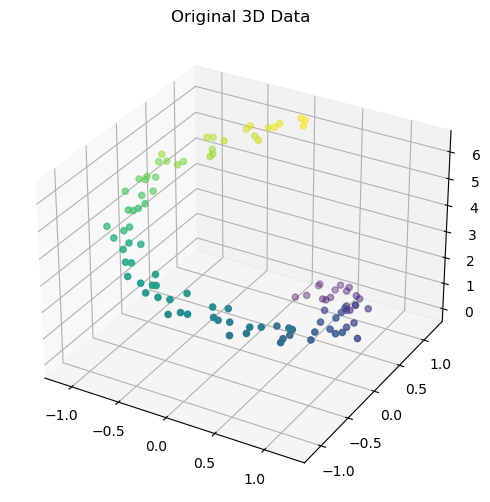

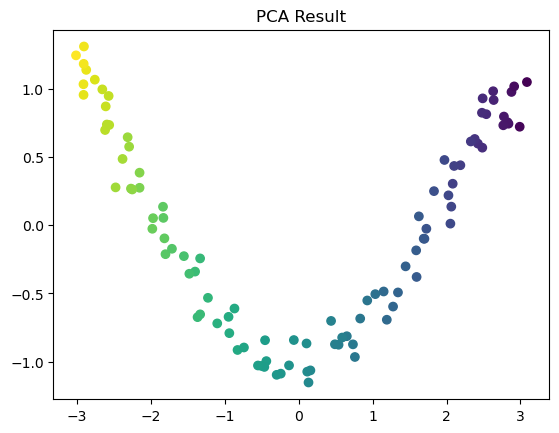

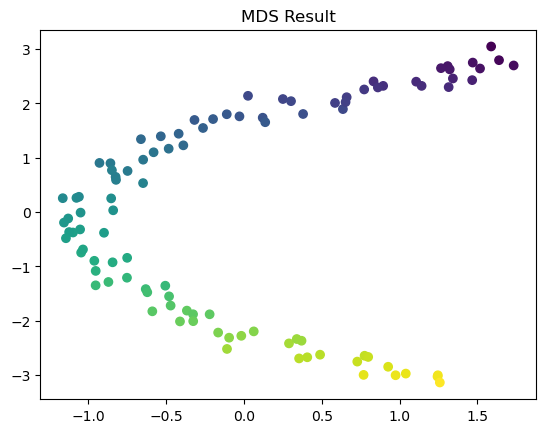

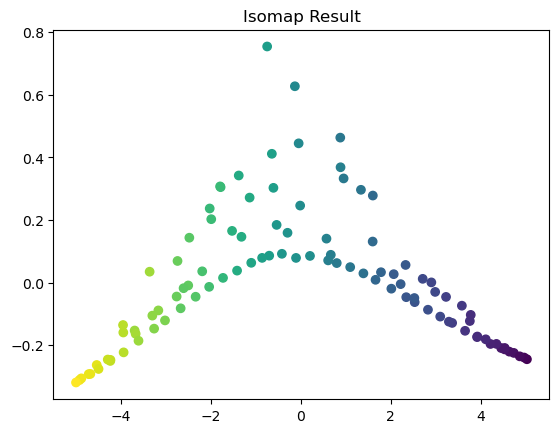

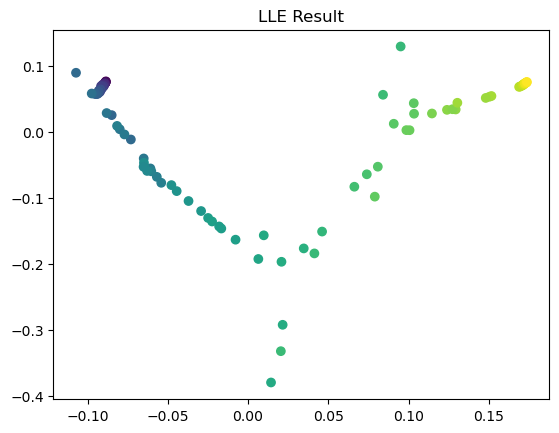

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding

# Generate synthetic dataset
def generate_synthetic_data():
    np.random.seed(0)
    t = np.linspace(0, 2 * np.pi, 100)
    x = np.sin(t) + 0.1 * np.random.randn(100)
    y = np.cos(t) + 0.1 * np.random.randn(100)
    z = t + 0.1 * np.random.randn(100)
    data = np.vstack([x, y, z]).T
    return data

# Plot the dataset in 3D
def plot_3d_data(data, title="Original Data"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2], cmap='viridis')
    ax.set_title(title)
    plt.show()

# PCA Implementation
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    return reduced_data

# MDS Implementation
def apply_mds(data, n_components=2):
    mds = MDS(n_components=n_components, random_state=0)
    reduced_data = mds.fit_transform(data)
    return reduced_data

# Isomap Implementation
def apply_isomap(data, n_components=2):
    isomap = Isomap(n_components=n_components)
    reduced_data = isomap.fit_transform(data)
    return reduced_data

# LLE Implementation
def apply_lle(data, n_components=2):
    lle = LocallyLinearEmbedding(n_components=n_components, random_state=0)
    reduced_data = lle.fit_transform(data)
    return reduced_data

# Main Script
data = generate_synthetic_data()
plot_3d_data(data, "Original 3D Data")

# Apply PCA
pca_result = apply_pca(data)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data[:, 2], cmap='viridis')
plt.title("PCA Result")
plt.show()

# Apply MDS
mds_result = apply_mds(data)
plt.scatter(mds_result[:, 0], mds_result[:, 1], c=data[:, 2], cmap='viridis')
plt.title("MDS Result")
plt.show()

# Apply Isomap
isomap_result = apply_isomap(data)
plt.scatter(isomap_result[:, 0], isomap_result[:, 1], c=data[:, 2], cmap='viridis')
plt.title("Isomap Result")
plt.show()

# Apply LLE
lle_result = apply_lle(data)
plt.scatter(lle_result[:, 0], lle_result[:, 1], c=data[:, 2], cmap='viridis')
plt.title("LLE Result")
plt.show()


In [10]:
import random
import math
from collections import defaultdict

def generate_3d_data(num_points=100):
    """Generate synthetic 3D data."""
    data = []
    for _ in range(num_points):
        x = random.uniform(-10, 10)
        y = random.uniform(-10, 10)
        z = x**2 + y**2
        data.append([x, y, z])
    return data

def mean(data):
    """Calculate the mean of each column in the data."""
    n = len(data)
    return [sum(row[i] for row in data) / n for i in range(len(data[0]))]

def center_data(data):
    """Center the data by subtracting the mean."""
    data_mean = mean(data)
    return [[x - data_mean[i] for i, x in enumerate(row)] for row in data]

def covariance_matrix(data):
    """Calculate the covariance matrix of the data."""
    n = len(data)
    dim = len(data[0])
    cov_matrix = [[0 for _ in range(dim)] for _ in range(dim)]
    for i in range(dim):
        for j in range(dim):
            cov_matrix[i][j] = sum(row[i] * row[j] for row in data) / n
    return cov_matrix

def eigen_decomposition(matrix):
    """Calculate eigenvalues and eigenvectors using the power iteration method."""
    dim = len(matrix)
    eigenvalues = []
    eigenvectors = []

    for _ in range(dim):
        vector = [random.random() for _ in range(dim)]
        for _ in range(100):  # Iterate for convergence
            # Multiply matrix by vector
            new_vector = [sum(matrix[i][j] * vector[j] for j in range(dim)) for i in range(dim)]
            # Normalize
            norm = math.sqrt(sum(x**2 for x in new_vector))
            vector = [x / norm for x in new_vector]
        
        # Rayleigh quotient for eigenvalue
        eigenvalue = sum(vector[i] * sum(matrix[i][j] * vector[j] for j in range(dim)) for i in range(dim))

        eigenvalues.append(eigenvalue)
        eigenvectors.append(vector)

        # Deflate matrix
        for i in range(dim):
            for j in range(dim):
                matrix[i][j] -= eigenvalue * vector[i] * vector[j]

    return eigenvalues, eigenvectors

def project_data(data, eigenvectors, k):
    """Project data onto the top-k eigenvectors."""
    return [[sum(row[j] * eigenvectors[i][j] for j in range(len(row))) for i in range(k)] for row in data]

def euclidean_distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(p1, p2)))

def compute_distances(data):
    """Compute pairwise distances between data points."""
    n = len(data)
    distances = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            distances[i][j] = distances[j][i] = euclidean_distance(data[i], data[j])
    return distances

def multidimensional_scaling(data, k):
    """Apply Multidimensional Scaling (MDS)."""
    distances = compute_distances(data)
    n = len(distances)

    # Double-center the distance matrix
    row_means = [sum(row) / n for row in distances]
    col_means = [sum(distances[i][j] for i in range(n)) / n for j in range(n)]
    total_mean = sum(row_means) / n

    b_matrix = [[-(distances[i][j]**2 - row_means[i] - col_means[j] + total_mean) / 2 for j in range(n)] for i in range(n)]

    # Eigen decomposition
    eigenvalues, eigenvectors = eigen_decomposition(b_matrix)

    # Select top-k components
    return project_data(data, eigenvectors, k)

# Main script
data = generate_3d_data()
centered_data = center_data(data)
cov_matrix = covariance_matrix(centered_data)
eigenvalues, eigenvectors = eigen_decomposition(cov_matrix)

# Apply PCA
projected_data_pca = project_data(centered_data, eigenvectors, k=2)

# Apply MDS
projected_data_mds = multidimensional_scaling(centered_data, k=2)

# Print results
print("PCA Projected Data:", projected_data_pca)
print("MDS Projected Data:", projected_data_mds)


PCA Projected Data: [[58.5866735557928, 10.437624715754753], [-33.29031284216351, -3.1160989870582028], [5.8084971636145735, 8.637337040997899], [47.107431673535075, -0.7071164516485072], [-5.3047504955095, -1.2030494127232556], [-14.033741280867588, -2.7999373936014074], [33.007210059347436, -8.991234528760724], [-4.2934646053679035, -0.607474858822799], [25.745684353481106, -8.16824075579632], [16.55818587455587, 8.656882890297345], [-2.8982208443309587, 4.026828049943199], [47.819479925204064, -8.806355728350061], [-3.326755390085825, 0.154937730160734], [-40.019777518392104, 1.396941749284336], [4.250388027097506, 8.470172483228168], [-11.969321981584002, -1.4381890698392155], [45.74434499665622, -0.16204408772254406], [12.853550146594285, 4.790409871383535], [61.92015674733693, -0.666999946787652], [33.50973056727834, -9.114550785375686], [46.25537630893096, -5.600145182044956], [-40.639664855428414, -1.734583559169792], [-52.81592665605224, 2.005328242943183], [-48.2267212097586,

PCA Projected Data: [[29.225473736207164, 7.534430660528217], [52.11054397397056, 9.867284872118798], [-28.043615958547978, -6.000912264501201], [-3.16124132237744, -5.704786722591308], [23.47389994355841, -9.152364082603341], [-10.41558434777019, -1.7454041743020736], [57.589617190160276, 10.061424161932933], [-16.7575085994347, -6.89615108072071], [32.56793245062954, 8.79815206310208], [-23.053062496534075, -5.389869932745901], [-10.464583414312001, 4.070484060022132], [1.647264897963495, 6.357961354905119], [-48.151522613321816, -3.092505399731496], [28.87133972820513, -6.816583506234699], [-60.107541431412926, -1.7528922903542323], [-11.756156894841395, 7.081018004598237], [14.352740529957295, 8.065532331811426], [62.50606752747139, -12.38921008456949], [-11.842625009716977, 4.928445157476824], [28.26979638287933, -5.907756197202364], [-3.1406057804616014, -3.1766221070371286], [-2.368244265596089, 5.1010125099630805], [-41.844914279811775, 5.1014947909423425], [-39.86030391314891,

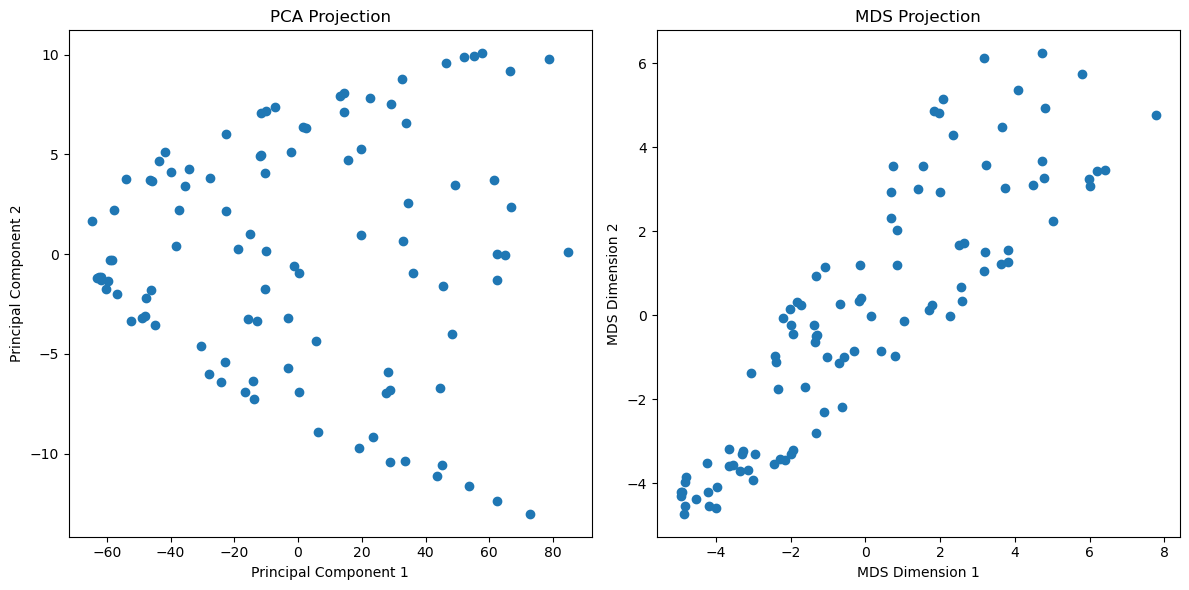

In [11]:
import random
import math
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_3d_data(num_points=100):
    """Generate synthetic 3D data."""
    data = []
    for _ in range(num_points):
        x = random.uniform(-10, 10)
        y = random.uniform(-10, 10)
        z = x**2 + y**2
        data.append([x, y, z])
    return data

def mean(data):
    """Calculate the mean of each column in the data."""
    n = len(data)
    return [sum(row[i] for row in data) / n for i in range(len(data[0]))]

def center_data(data):
    """Center the data by subtracting the mean."""
    data_mean = mean(data)
    return [[x - data_mean[i] for i, x in enumerate(row)] for row in data]

def covariance_matrix(data):
    """Calculate the covariance matrix of the data."""
    n = len(data)
    dim = len(data[0])
    cov_matrix = [[0 for _ in range(dim)] for _ in range(dim)]
    for i in range(dim):
        for j in range(dim):
            cov_matrix[i][j] = sum(row[i] * row[j] for row in data) / n
    return cov_matrix

def eigen_decomposition(matrix):
    """Calculate eigenvalues and eigenvectors using the power iteration method."""
    dim = len(matrix)
    eigenvalues = []
    eigenvectors = []

    for _ in range(dim):
        vector = [random.random() for _ in range(dim)]
        for _ in range(100):  # Iterate for convergence
            # Multiply matrix by vector
            new_vector = [sum(matrix[i][j] * vector[j] for j in range(dim)) for i in range(dim)]
            # Normalize
            norm = math.sqrt(sum(x**2 for x in new_vector))
            vector = [x / norm for x in new_vector]
        
        # Rayleigh quotient for eigenvalue
        eigenvalue = sum(vector[i] * sum(matrix[i][j] * vector[j] for j in range(dim)) for i in range(dim))

        eigenvalues.append(eigenvalue)
        eigenvectors.append(vector)

        # Deflate matrix
        for i in range(dim):
            for j in range(dim):
                matrix[i][j] -= eigenvalue * vector[i] * vector[j]

    return eigenvalues, eigenvectors

def project_data(data, eigenvectors, k):
    """Project data onto the top-k eigenvectors."""
    return [[sum(row[j] * eigenvectors[i][j] for j in range(len(row))) for i in range(k)] for row in data]

def euclidean_distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(p1, p2)))

def compute_distances(data):
    """Compute pairwise distances between data points."""
    n = len(data)
    distances = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            distances[i][j] = distances[j][i] = euclidean_distance(data[i], data[j])
    return distances

def multidimensional_scaling(data, k):
    """Apply Multidimensional Scaling (MDS)."""
    distances = compute_distances(data)
    n = len(distances)

    # Double-center the distance matrix
    row_means = [sum(row) / n for row in distances]
    col_means = [sum(distances[i][j] for i in range(n)) / n for j in range(n)]
    total_mean = sum(row_means) / n

    b_matrix = [[-(distances[i][j]**2 - row_means[i] - col_means[j] + total_mean) / 2 for j in range(n)] for i in range(n)]

    # Eigen decomposition
    eigenvalues, eigenvectors = eigen_decomposition(b_matrix)

    # Select top-k components
    return project_data(data, eigenvectors, k)

# Main script
data = generate_3d_data()
centered_data = center_data(data)
cov_matrix = covariance_matrix(centered_data)
eigenvalues, eigenvectors = eigen_decomposition(cov_matrix)

# Apply PCA
projected_data_pca = project_data(centered_data, eigenvectors, k=2)

# Apply MDS
projected_data_mds = multidimensional_scaling(centered_data, k=2)

# Print results
print("PCA Projected Data:", projected_data_pca)
print("MDS Projected Data:", projected_data_mds)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot PCA
axes[0].scatter([point[0] for point in projected_data_pca], [point[1] for point in projected_data_pca])
axes[0].set_title('PCA Projection')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# Plot MDS
axes[1].scatter([point[0] for point in projected_data_mds], [point[1] for point in projected_data_mds])
axes[1].set_title('MDS Projection')
axes[1].set_xlabel('MDS Dimension 1')
axes[1].set_ylabel('MDS Dimension 2')

plt.tight_layout()
plt.show()


## Geodesic Distance, MDS, and Latent Variable Models

### Geodesic Distance in Multidimensional Scaling (MDS)

In Multidimensional Scaling (MDS), the distance between two points is not always the straight-line Euclidean distance, especially when the data points lie on a curved manifold. For example, if two points lie on a circle, the geodesic distance is the arc-length distance along the circle's circumference, not the straight-line distance (i.e., the chord). The steps for MDS are as follows:

1. **Neighborhood Definition**: 
   - For each data point, find the *K* nearest neighbors or all points within a sphere of radius $ \epsilon $.
   
2. **Graph Construction**: 
   - Create a graph by connecting neighboring points and labeling edges with the Euclidean distance between them.

3. **Geodesic Distance Calculation**:
   - The geodesic distance between any pair of points is approximated by the sum of the arc lengths along the shortest path connecting them. This path is found using standard algorithms (e.g., Dijkstra's algorithm).

4. **Metric MDS**:
   - Once the geodesic distance matrix is computed, Metric MDS is applied to find the low-dimensional projection.

## Latent Variable Models

### Continuous and Discrete Variables

The models we've discussed so far have continuous observed variables. However, we can also consider models with continuous latent variables and discrete observed variables. These models are referred to as **latent trait models** (Bartholomew, 1987). In such models:

- The marginalization over the continuous latent variables, even for a linear relationship between latent and observed variables, cannot be performed analytically.
- More sophisticated techniques, such as **variational inference** (Tipping, 1999), are used in these cases. These methods allow visualization of binary datasets analogous to how PCA is used for continuous data.
- This approach is the dual of the **Bayesian logistic regression** problem discussed in Section 4.5, where instead of a feature vector $ \mathbf{w} $, we have a latent variable $ \mathbf{x} $ and $ N $ copies of this latent variable.

### Density Networks and General Latent Variable Models

A **density network** (MacKay, 1995) is a general latent variable model where the nonlinearity is governed by a multilayered neural network. This model can approximate a given nonlinear function with arbitrary precision. However, the downside of such flexibility is that marginalization over the latent variables becomes computationally expensive and is approximated using **Monte Carlo** techniques. To make this model more efficient:

- A **Generative Topographic Mapping (GTM)** is introduced. The latent distribution is defined by a **finite grid of delta functions** over the latent space (typically 2D). Marginalization is simpler in this case as it involves summing over grid locations.

### Comparison of PCA and GTM

- The **GTM model** can represent nonlinear manifolds and is capable of separating groups of data points more clearly than PCA.
- **PCA**, on the other hand, is linear and may fail to capture complex nonlinear structures in the data.

In the figure below, we compare **PCA** and **GTM** projections of the oil flow data set:

$$ \text{Figure: Oil Flow Data Visualized with PCA (Left) and GTM (Right)} $$

The GTM model uses a probabilistic approach, and it defines a smooth manifold in latent space. This is in contrast to the **Self-Organizing Map (SOM)**, which is a more heuristic, non-optimization-based approach that attempts to represent a manifold by organizing data points into a 2D array of prototype vectors. However, SOM does not guarantee convergence and lacks a clear cost function to optimize.

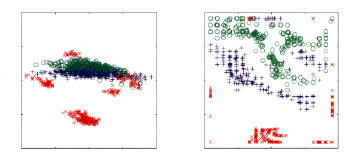

Fig.21 Plot of the oil flow data set visualized using PCA on the left and GTM on the right. For the GTM model, each data point is plotted at the mean of its posterior distribution in latent space. The nonlinearity of the GTM model allows the separation between the groups of data points to be seen more clearly


### The Generative Topographic Mapping (GTM) Model

The GTM model can be viewed as a **probabilistic version** of SOM. Unlike SOM, GTM optimizes the log-likelihood function and defines a **probability density** in data space. It is essentially a **mixture of Gaussians** where the means lie on a 2D manifold.

- **Optimizing the Likelihood**: GTM fits a nonlinear manifold to the data using the Expectation-Maximization (EM) algorithm, allowing for efficient training and closed-form analytical expressions for the likelihood.

The GTM model can be used to fit a **two-dimensional manifold** to data, and by evaluating the posterior distribution over latent space, we can project the data points back to the latent space for visualization purposes.

GTM Model Likelihood: $\quad p(\mathbf{x}_i | \mathbf{w}, \theta)$

In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Function to generate synthetic 3D data
def generate_3d_data(num_points=100):
    data = []
    for _ in range(num_points):
        x = random.uniform(-10, 10)
        y = random.uniform(-10, 10)
        z = x**2 + y**2  # A non-linear relationship between x, y, and z
        data.append([x, y, z])
    return np.array(data)

# Function to compute Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.linalg.norm(p1 - p2)

# Function to compute pairwise distances between all data points
def compute_distances(data):
    n = data.shape[0]
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = euclidean_distance(data[i], data[j])
            distances[i, j] = distances[j, i] = dist
    return distances

# Metric MDS implementation
def metric_mds(distances, k):
    # Double-center the distance matrix
    n = distances.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n  # centering matrix
    B = -0.5 * H @ (distances ** 2) @ H  # Gram matrix
    
    # Eigen decomposition of B
    eigvals, eigvecs = np.linalg.eigh(B)
    
    # Sort the eigenvalues and eigenvectors in decreasing order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Select the top-k eigenvectors
    X = eigvecs[:, :k] * np.sqrt(eigvals[:k])
    
    return X

# Generative Topographic Mapping (GTM) - simple version with grid points
def gtm(data, latent_dim=2, num_grid_points=10):
    # Define a regular grid of points in latent space
    grid_points = np.linspace(-5, 5, num_grid_points)
    X_latent = np.array(np.meshgrid(grid_points, grid_points)).T.reshape(-1, 2)
    
    # Fit a simple linear model from latent space to data space (for simplicity)
    # We assume each point in the latent space corresponds to a Gaussian distribution in data space
    # For a more sophisticated approach, we would use EM algorithm, but this is a simple version
    data_mean = np.mean(data, axis=0)
    data_cov = np.cov(data, rowvar=False)
    
    latent_data = []
    for latent_point in X_latent:
        # Transform latent points to the data space using the Gaussian model
        latent_data.append(data_mean + latent_point)
    
    return np.array(latent_data)

# Visualize the results of PCA, MDS, and GTM
def visualize_projections(data, pca_data, mds_data, gtm_data):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].scatter(pca_data[:, 0], pca_data[:, 1], c='r')
    axes[0].set_title("PCA Projection")
    
    axes[1].scatter(mds_data[:, 0], mds_data[:, 1], c='g')
    axes[1].set_title("MDS Projection")
    
    axes[2].scatter(gtm_data[:, 0], gtm_data[:, 1], c='b')
    axes[2].set_title("GTM Projection")
    
    plt.show()

# Main script
data = generate_3d_data(100)  # Generate 100 3D points

# Apply PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

# Apply MDS
distances = compute_distances(data)
mds_data = metric_mds(distances, k=2)

# Apply GTM (using a simple grid-based approach for visualization)
gtm_data = gtm(data)

# Visualize the projections
visualize_projections(data, pca_data, mds_data, gtm_data)


## Data Projection Techniques: PCA, MDS, and GTM

In this notebook, we explore three different techniques to reduce the dimensionality of a dataset: **Principal Component Analysis (PCA)**, **Multidimensional Scaling (MDS)**, and **Generative Topographic Mapping (GTM)**. Each of these methods is used to project a dataset from a higher-dimensional space into a lower-dimensional space, and they have different characteristics in how they handle the data.



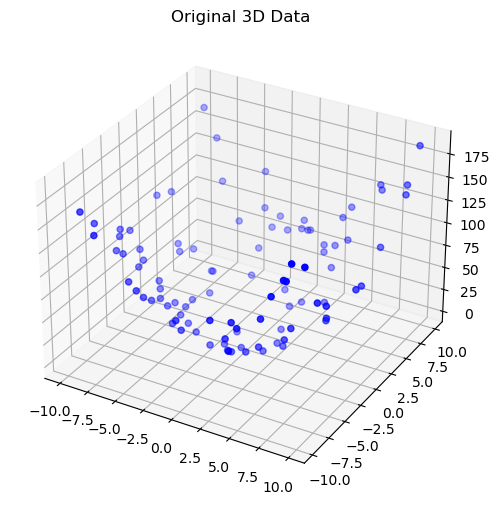

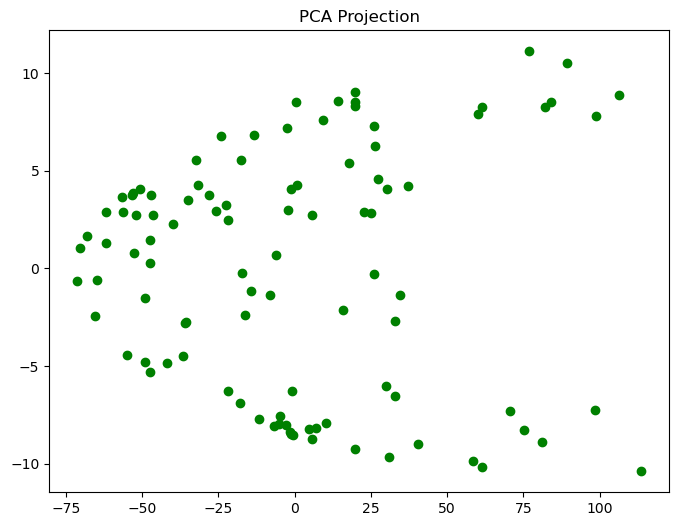

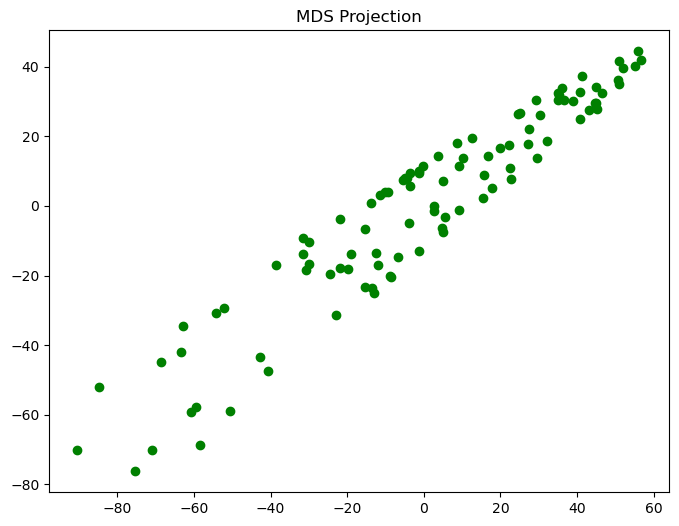

ValueError: X has 3 features, but NearestNeighbors is expecting 2 features as input.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist

# 1. Generate synthetic 3D data (with some structure)
def generate_3d_data(num_points=100):
    """Generate synthetic 3D data."""
    data = []
    for _ in range(num_points):
        x = np.random.uniform(-10, 10)
        y = np.random.uniform(-10, 10)
        z = x**2 + y**2  # Nonlinear relationship
        data.append([x, y, z])
    return np.array(data)

# 2. Apply PCA for dimensionality reduction
def apply_pca(data, n_components=2):
    """Reduce dimensionality using PCA."""
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

# 3. Apply MDS (Multidimensional Scaling)
def apply_mds(data, n_components=2):
    """Reduce dimensionality using MDS."""
    mds = MDS(n_components=n_components, dissimilarity='euclidean', random_state=42)
    return mds.fit_transform(data)

# 4. GTM Implementation (simplified)
def apply_gtm(data, n_components=2, latent_grid_size=(10, 10)):
    """
    Apply a simplified Generative Topographic Mapping (GTM).
    For simplicity, the latent space is a 2D grid, and we'll use a very basic fitting process.
    """
    # Step 1: Create a grid of latent variables
    grid_x = np.linspace(-1, 1, latent_grid_size[0])
    grid_y = np.linspace(-1, 1, latent_grid_size[1])
    latent_grid = np.array(np.meshgrid(grid_x, grid_y)).T.reshape(-1, 2)

    # Step 2: Map the grid to the data space using a linear model (simplified)
    # Assume a linear mapping from latent space to data space
    # For simplicity, just use a basic nearest-neighbor mapping
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(latent_grid)
    
    # Find the closest latent variable for each data point
    _, indices = nn.kneighbors(data)
    latent_projection = latent_grid[indices.flatten()]

    return latent_projection

# 5. Visualize the results
def plot_3d_data(data, title='3D Data'):
    """Visualize the 3D data."""
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', marker='o')
    ax.set_title(title)
    plt.show()

def plot_2d_data(data, title='2D Projection'):
    """Visualize 2D projections of the data."""
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c='green', marker='o')
    plt.title(title)
    plt.show()

# Main script
if __name__ == "__main__":
    # Step 1: Generate synthetic 3D data
    data = generate_3d_data(num_points=100)

    # Visualize the original 3D data
    plot_3d_data(data, title='Original 3D Data')

    # Step 2: Apply PCA
    pca_result = apply_pca(data, n_components=2)
    plot_2d_data(pca_result, title='PCA Projection')

    # Step 3: Apply MDS
    mds_result = apply_mds(data, n_components=2)
    plot_2d_data(mds_result, title='MDS Projection')

    # Step 4: Apply GTM (Generative Topographic Mapping)
    gtm_result = apply_gtm(data, n_components=2, latent_grid_size=(10, 10))
    plot_2d_data(gtm_result, title='GTM Projection')
